In [1]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut

import time

## System initializer

In [2]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 100., 200., 300., 400.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    #tank_current_loads = tank_max_loads.copy()
    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])

        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load  

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([20., 50.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([20., 20., 20., 20., 20., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [3]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
#print([load for load in system.tank_loads])

[77, 40, 157, 147, 289]


In [4]:
print(system.tank_loads())
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)
        tank.load = current_load  
        
reinitialize_system(system,3)
print(system.tank_loads())
reinitialize_system(system,4)
print(system.tank_loads())


[77, 40, 157, 147, 289]
[50, 29, 51, 97, 248]
[72, 81, 180, 180, 188]


## Q-learning algorithm (off-policy)


### Training

In [5]:
# Train parameters:
retrain = False
train_epsilon = True

learning_rate0 = 0.05 #??
learning_rate_decay = 0.1 #??

episodes = 1000 #episodes
train_freq = 10
episode_length = 100

discount_rate = 0.95

epsilon0 = 1.0
epsilon_decay = 0.1*episodes

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 10

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [6]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = epsilon0 / (1+(episode-1)*epsilon_decay)
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
                
        system.reset_trucks_positions();
        system.reset_trucks_loads();

        if episode % freq == 0:
                time_end = time.time()
                print("Episode ", episode, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.","epsilon", epsilon )
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)

                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());    

                ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
        rewards_list.append(discounted_reward);
        ut.save_obj(rewards_list, "discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
   
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [7]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [8]:
# def train_Q_epsilon( epsilon0 = epsilon0,
#             n_iterations = train_iterations, 
#             learning_rate0 = learning_rate0,
#             learning_rate_decay = learning_rate_decay,
#             discount_rate = discount_rate,
#             system = toy_system,
#             Q = Q, verbose = verbose, verbose_info = verbose_info,
#             visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
#             seed = seed, 
#             freq = train_freq,
#             simulation_id = simulation_id,
#             round_time = 2
#            ):
    
#     time_start = time.time()
        
#     for iteration in range(1, n_iterations+1):
        
#         system.update_state()
#         s_current = system.state_to_string()


#         if verbose: print("System state before, ", toy_system.ds)
            
#         ### epsilon-greedy exploration
#         epsilon = epsilon0 / (1+(iteration-1)*epsilon_decay)
#         p = np.random.uniform()
        
#         if p > epsilon:
#             #DETERMINISTIC ACTION OPTIMAL
#             s0 = system.state_to_string()
#             best_action = optimal_policy(s0, Q)
#             if best_action == None:
#                 reward = system.random_action(seed = (seed + iteration), verbose = verbose)
#             else:
#                 reward = system.deterministic_action(best_action)
#             #print(best_action)
#         else:
#             reward = system.random_action(seed = (seed + iteration), verbose = verbose)
        
#         a_current = system.action_to_string()
#         sa_current = ''.join([s_current, a_current])
                
#         system.update_state()
#         sa_new = system.state_action_to_string()
         
#         if ut.is_key(Q, sa_current) == False:
#             Q[sa_current] = 0

#         learning_rate = learning_rate0 / (1+(iteration-1)*learning_rate_decay)        

#         Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 
        
#         if Q[sa_current] != -np.inf:
#             Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
#                              + learning_rate* (reward + discount_rate * Q_max)
#                             )
#         if verbose &  (iteration % freq == 0):
#             print("System state after, ", system.ds)
#             print("System action after, ", system.da)
#             print("sa current, ", sa_current)

#         system.reset_trucks_positions();
#         system.reset_trucks_loads();

#         if iteration % freq == 0:
#             time_end = time.time()
#             print("Iteration ", iteration, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.","epsilon", epsilon )
#             if verbose_info:
#                 print("s, a", system.s, system.a)
#                 print("ds, da", system.ds, system.da)
                
#             #Save visualization and rewards
#             rewards_list.append(reward);
#             visualization_steps.append(toy_system.visualize());    

#             ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
#             ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")   
#             ut.save_obj(rewards_list, "rewards/rew-train-sim" + f"{simulation_id}" + "-" + f"{iteration}")
#     end_time = round(time.time()-time_start,round_time)        
#     print(f"Training finished. Total iterations: {n_iterations}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [9]:
if train_epsilon == True:
    #train_Q_epsilon()
    episodic_train_Q_epsilon()

Episode  1 , Elapsed time  0.0  minuts. epsilon 1.0
Episode  2 , Elapsed time  0.0  minuts. epsilon 0.5
Episode  3 , Elapsed time  0.0  minuts. epsilon 0.3333333333333333
Episode  4 , Elapsed time  0.01  minuts. epsilon 0.25
Episode  5 , Elapsed time  0.01  minuts. epsilon 0.2
Episode  6 , Elapsed time  0.01  minuts. epsilon 0.16666666666666666
Episode  7 , Elapsed time  0.01  minuts. epsilon 0.14285714285714285
Episode  8 , Elapsed time  0.01  minuts. epsilon 0.125
Episode  9 , Elapsed time  0.01  minuts. epsilon 0.1111111111111111
Episode  10 , Elapsed time  0.01  minuts. epsilon 0.1
Training finished. Total episodes: 10. Elapsed time: 0.01 minuts.


### Testing

In [19]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#Load trained Q-values
# if train == False:
#     simulation_id = 8
#     train_iterations = 20*10**5
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


# if retrain == False:
#     simulation_id = 7
#     train_iterations = 259*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

   
#test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length = 100
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []

In [20]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward


        #Save rewards
        if i % freq == 0:
                rewards_list.append(discounted_reward);


In [21]:
test_Q()

In [22]:
# Visualizing test simulation:
test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())



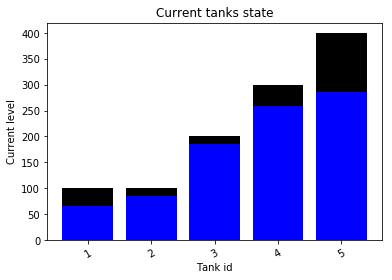

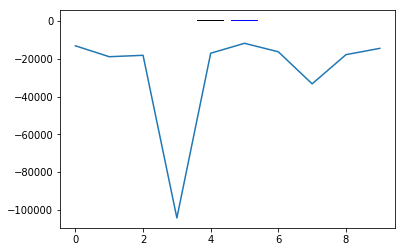

In [18]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
plt.show()

In [ ]:
# Visualizing train simulation:
train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
HTML(train_anim.to_html5_video())

In [ ]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))